### Punto 2

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        
        self.f = self.m*self.a
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.VEk = np.zeros(len(t))
        # Tarea
        self.Ep = 0
        self.L = np.zeros(len(t))
        self.VEp = np.zeros(len(t))
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        
        self.a = self.f/self.m
        
        # Euler
  #      self.r += self.dt*self.v
  #      self.v += self.dt*self.a
        
        # Euler-Cromer
        self.v += self.dt*self.a
        self.v[1] += -9.8*self.dt
        self.r += self.dt*self.v
        
    def CalculateForce(self,p):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            # Falta implementar energía potencial 
            self.Ep = (1/4)*self.K*compresion**4
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        self.P[i] = self.m*self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)
        # Agregados para la tarea:
        self.L[i] = np.cross(self.r,self.m*self.v)
        self.VEp[i] = self.Ep
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale]

    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]

    def GetPotential(self, scale=1):
        return self.VEp[::scale]
    # Debes agregar las paredes en este punto
    def CheckLimits(self):
        
        for i in range(2):
            
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i]*0.9
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i]*0.9

In [3]:
def GetParticles(N,t):
    
    Particles = []
    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0.])
    a0 = np.array([0.,0.])
    
    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)

    Particles.append(p0)
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [4]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [5]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared
            
            
    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|█████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 10679.67 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

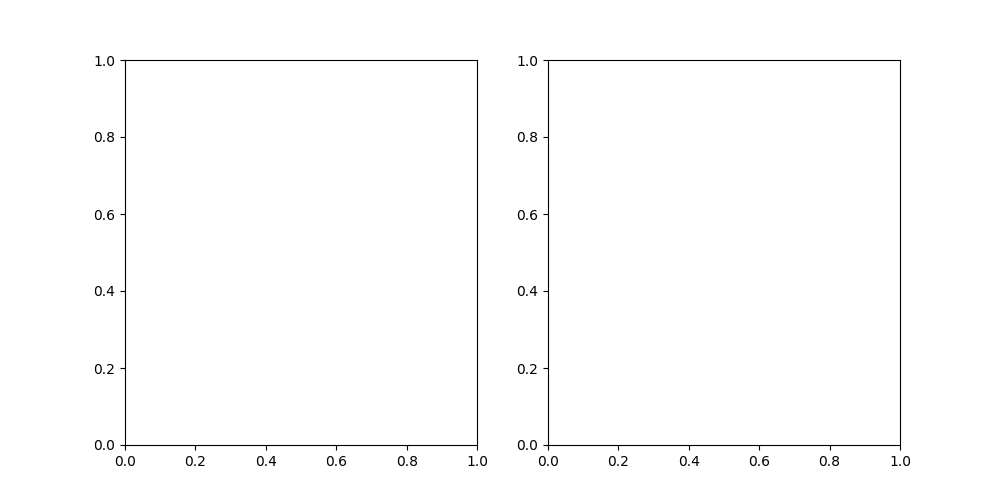

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=True )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KE += p.GetKineticEnergy(scale)[i]
        
        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [9]:
MomentumT = Particles[0].GetMomentum(scale)

In [10]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

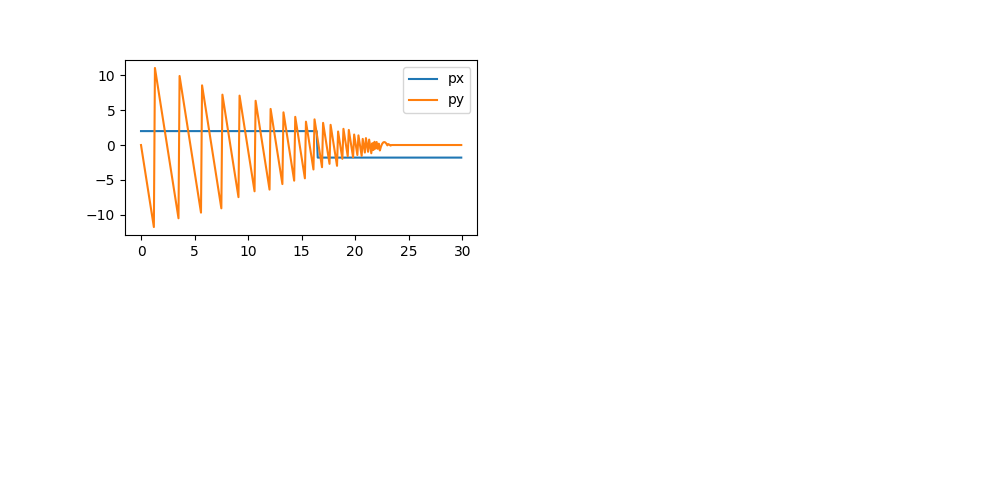

In [11]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.legend()

In [12]:
MomentoAngular = 0
EnergiaCinetica = 0
EnergiaPotencial = 0
for particula in Particles:
    MomentoAngular = np.add(MomentoAngular, particula.GetAngularMomentum(scale))
    EnergiaCinetica += particula.GetKineticEnergy(scale)
    EnergiaPotencial += particula.GetPotential(scale)/2
EnergiaMecanica = EnergiaCinetica + EnergiaPotencial

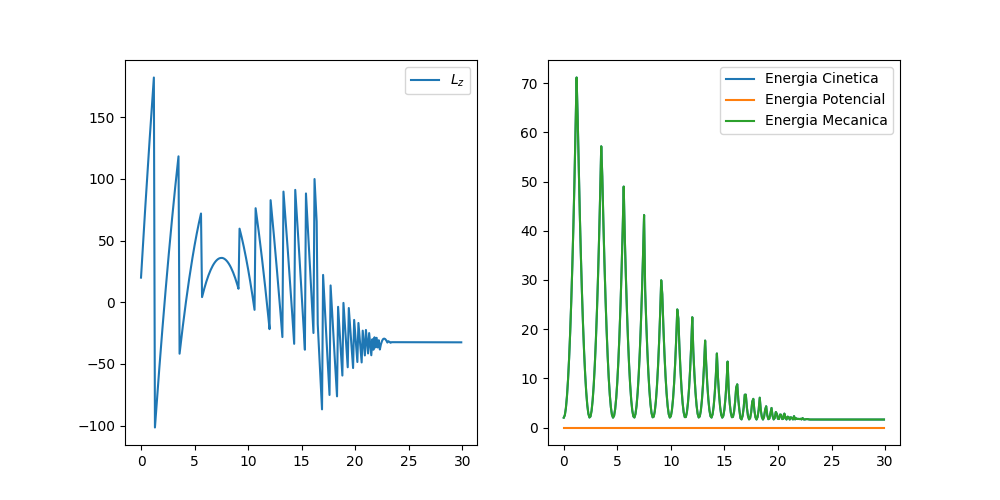

In [13]:
fig4 = plt.figure(figsize=(10,5))
ax4 = fig4.add_subplot(121)
ax5 = fig4.add_subplot(122)

ax4.plot(t1,MomentoAngular,label="$L_z$")
ax4.plot(0,0)

ax5.plot(t1,EnergiaCinetica,label='Energia Cinetica')
ax5.plot(t1,EnergiaPotencial,label='Energia Potencial')
ax5.plot(t1,EnergiaMecanica,label='Energia Mecanica')

ax4.legend()
ax5.legend()

# A
---
En este caso comenzamos tomando en cuenta que con las alturas podemos encontrar las velocidades cuando la energia cinetica es maxima que en este caso para cada movimiento corresponde al instante justo antes de chocar y al instante justo despues de chocar. Por lo tanto con estas podemos desarrollar como sigue:
$$
\begin{align*}
U_0 = m\cdot g \cdot h_o\\
U_0 = K_0\\
m \cdot g \cdot h_0 = \frac{1}{2} m\cdot v^2\\
\sqrt{2\cdot g \cdot h_o} = v\\
\end{align*}
$$

Esto mismo aplica a la energia cinetica obtenida en el punto maximo del segundo movimiento. Ahora bien, para calcular el coeficiente de resitución podriamos dividir ambas velocidades (pues eso nos dejaria con el porcentaje de velocidad que sobrevivio).
$$
\begin{align*}
\frac{V_1}{V_0} = \frac{\sqrt{2\cdot g\cdot h_1}}{\sqrt{2\cdot g \cdot h_0}}\\
e = \sqrt{\frac{h_1}{h_0}}
\end{align*}
$$

# B
---
Lo que podemos hacer en este caso como vemos, la velocidad en y cae relativamente rapido quedandose quieta ligeramente antes de los 25 segundos. Sin embargo la velocidad en $x$ tomara mucho mas tiempo pues debera chocar contra las paredes laterales varias veces. Dado que inicia en 2 podemos hacer un ciclo y con eso ver que cuando se haya revotado $357$ veces la velocidad seria $9.238593649316885\times 10^{-17}$ que ya para ese punto la velocidad seria imperceptible.

In [14]:
velocidad = 2
contador = 0
while velocidad > 0.0000000000000001:
    velocidad = velocidad*0.9
    contador += 1
    if contador > 1000:
        break
print(velocidad)
print(contador)

9.238593649316885e-17
357


# C
---
Como habiamos puesto antes, para calcular la restitución solo necesitamos la altura maxima del movimiento anterior y la altura maxima de este ciclo. Con eso entonces, tomando que la altura inicial es -10 y como notamos en el siguiente la altura es -11 por lo tanto

In [18]:
p = Particles[0]
y = p.GetPosition(scale)[:,1]
y

SyntaxError: incomplete input (2348260329.py, line 3)